# Solving linear equation with Feynmann-Kac

In [1]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
font = font_manager.FontProperties(style='normal', size=20)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_dtype(torch.float32) # improved the speed when the parameters are float32
import random

import json

from IPython.display import display, Math, Markdown

import datetime
import os
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
timestamp
version = '_0.1.0'
import math
PI = math.pi

# Wiener process

$$\begin{cases}
V_t+\frac{1}{2}\Delta V + C(x) = 0\\
V(T,x)=g(x)\end{cases}$$

Approximate $V(0,0)$ when $C(x)= \begin{cases}1-\max_{i}|x_i|&x\in[-1,1]^d\\ 0& \text{otherwise}\end{cases}$ and $g(x)=1\!\!1_{[-1,1]^2}$



$$V(0,x)=\mathbb{E}\left[\int_0^T C(X_r){{dr}}+g(X_T)\Big|X_0=x\right]\approx\frac{1}{J}\Big(\sum_{n=0}^{N-1} C(\hat{X}_{t_n}^j)\Delta t+g(\hat{X}_T^j)\Big)$$


Take $T=1$



## First do the approximation for $x=0$

In [2]:
N = 20 # number of time steps
T = 1. # terminal time
dt = T/N # time step
d = 2 # dimension of the Wiener process
num_samples = 5_000 # Modify the number of samples
dW = torch.sqrt(torch.tensor(dt))*torch.randn([num_samples,N+1,d]) # Brownian increments
dW[:,0,:]=0.0 # first increment is zero
W = torch.cumsum(dW, dim=1) # Wiener process paths

def running_cost(x):
    max_val, _ = torch.max(torch.abs(x),dim=2)
    return torch.max(torch.zeros_like(max_val), 1 - max_val)*dt

def terminal_cost(x):
    return (torch.sign(1-x)+1)*(torch.sign(x+1)+1)/4

In [3]:
x = torch.Tensor([0.,1.])
torch.sum(running_cost(x.repeat([num_samples, N,1])+W[:,:-1,:]), dim=1).shape,terminal_cost(x.repeat([num_samples,1])+W[:,-1,:]).prod(dim=1).shape

(torch.Size([5000]), torch.Size([5000]))

In [4]:
def fk_eval(x):
    return torch.mean(torch.sum(running_cost(x.repeat([num_samples, N,1])+W[:,:-1,:]), dim=1) + terminal_cost(x.repeat([num_samples,1])+W[:,-1,:]).prod(dim=1))

In [5]:
fk_eval(torch.Tensor([0.]*d))

tensor(0.8270)

## Next do the approximation for $t=0$ at $x\in[-10,10]$

# Dirty quick job

In [24]:
x = torch.linspace(-10,10,100)
y = torch.linspace(-10,10,100)
X, Y = torch.meshgrid(x,y, indexing='ij')
X_flat = X.flatten()
Y_flat = Y.flatten()
xy = torch.stack([X_flat, Y_flat], dim=1)
z = torch.zeros(xy.shape[0])
for i in range(xy.shape[0]):
    z[i] = fk_eval(xy[i,:])
# xy.shape, z.shape

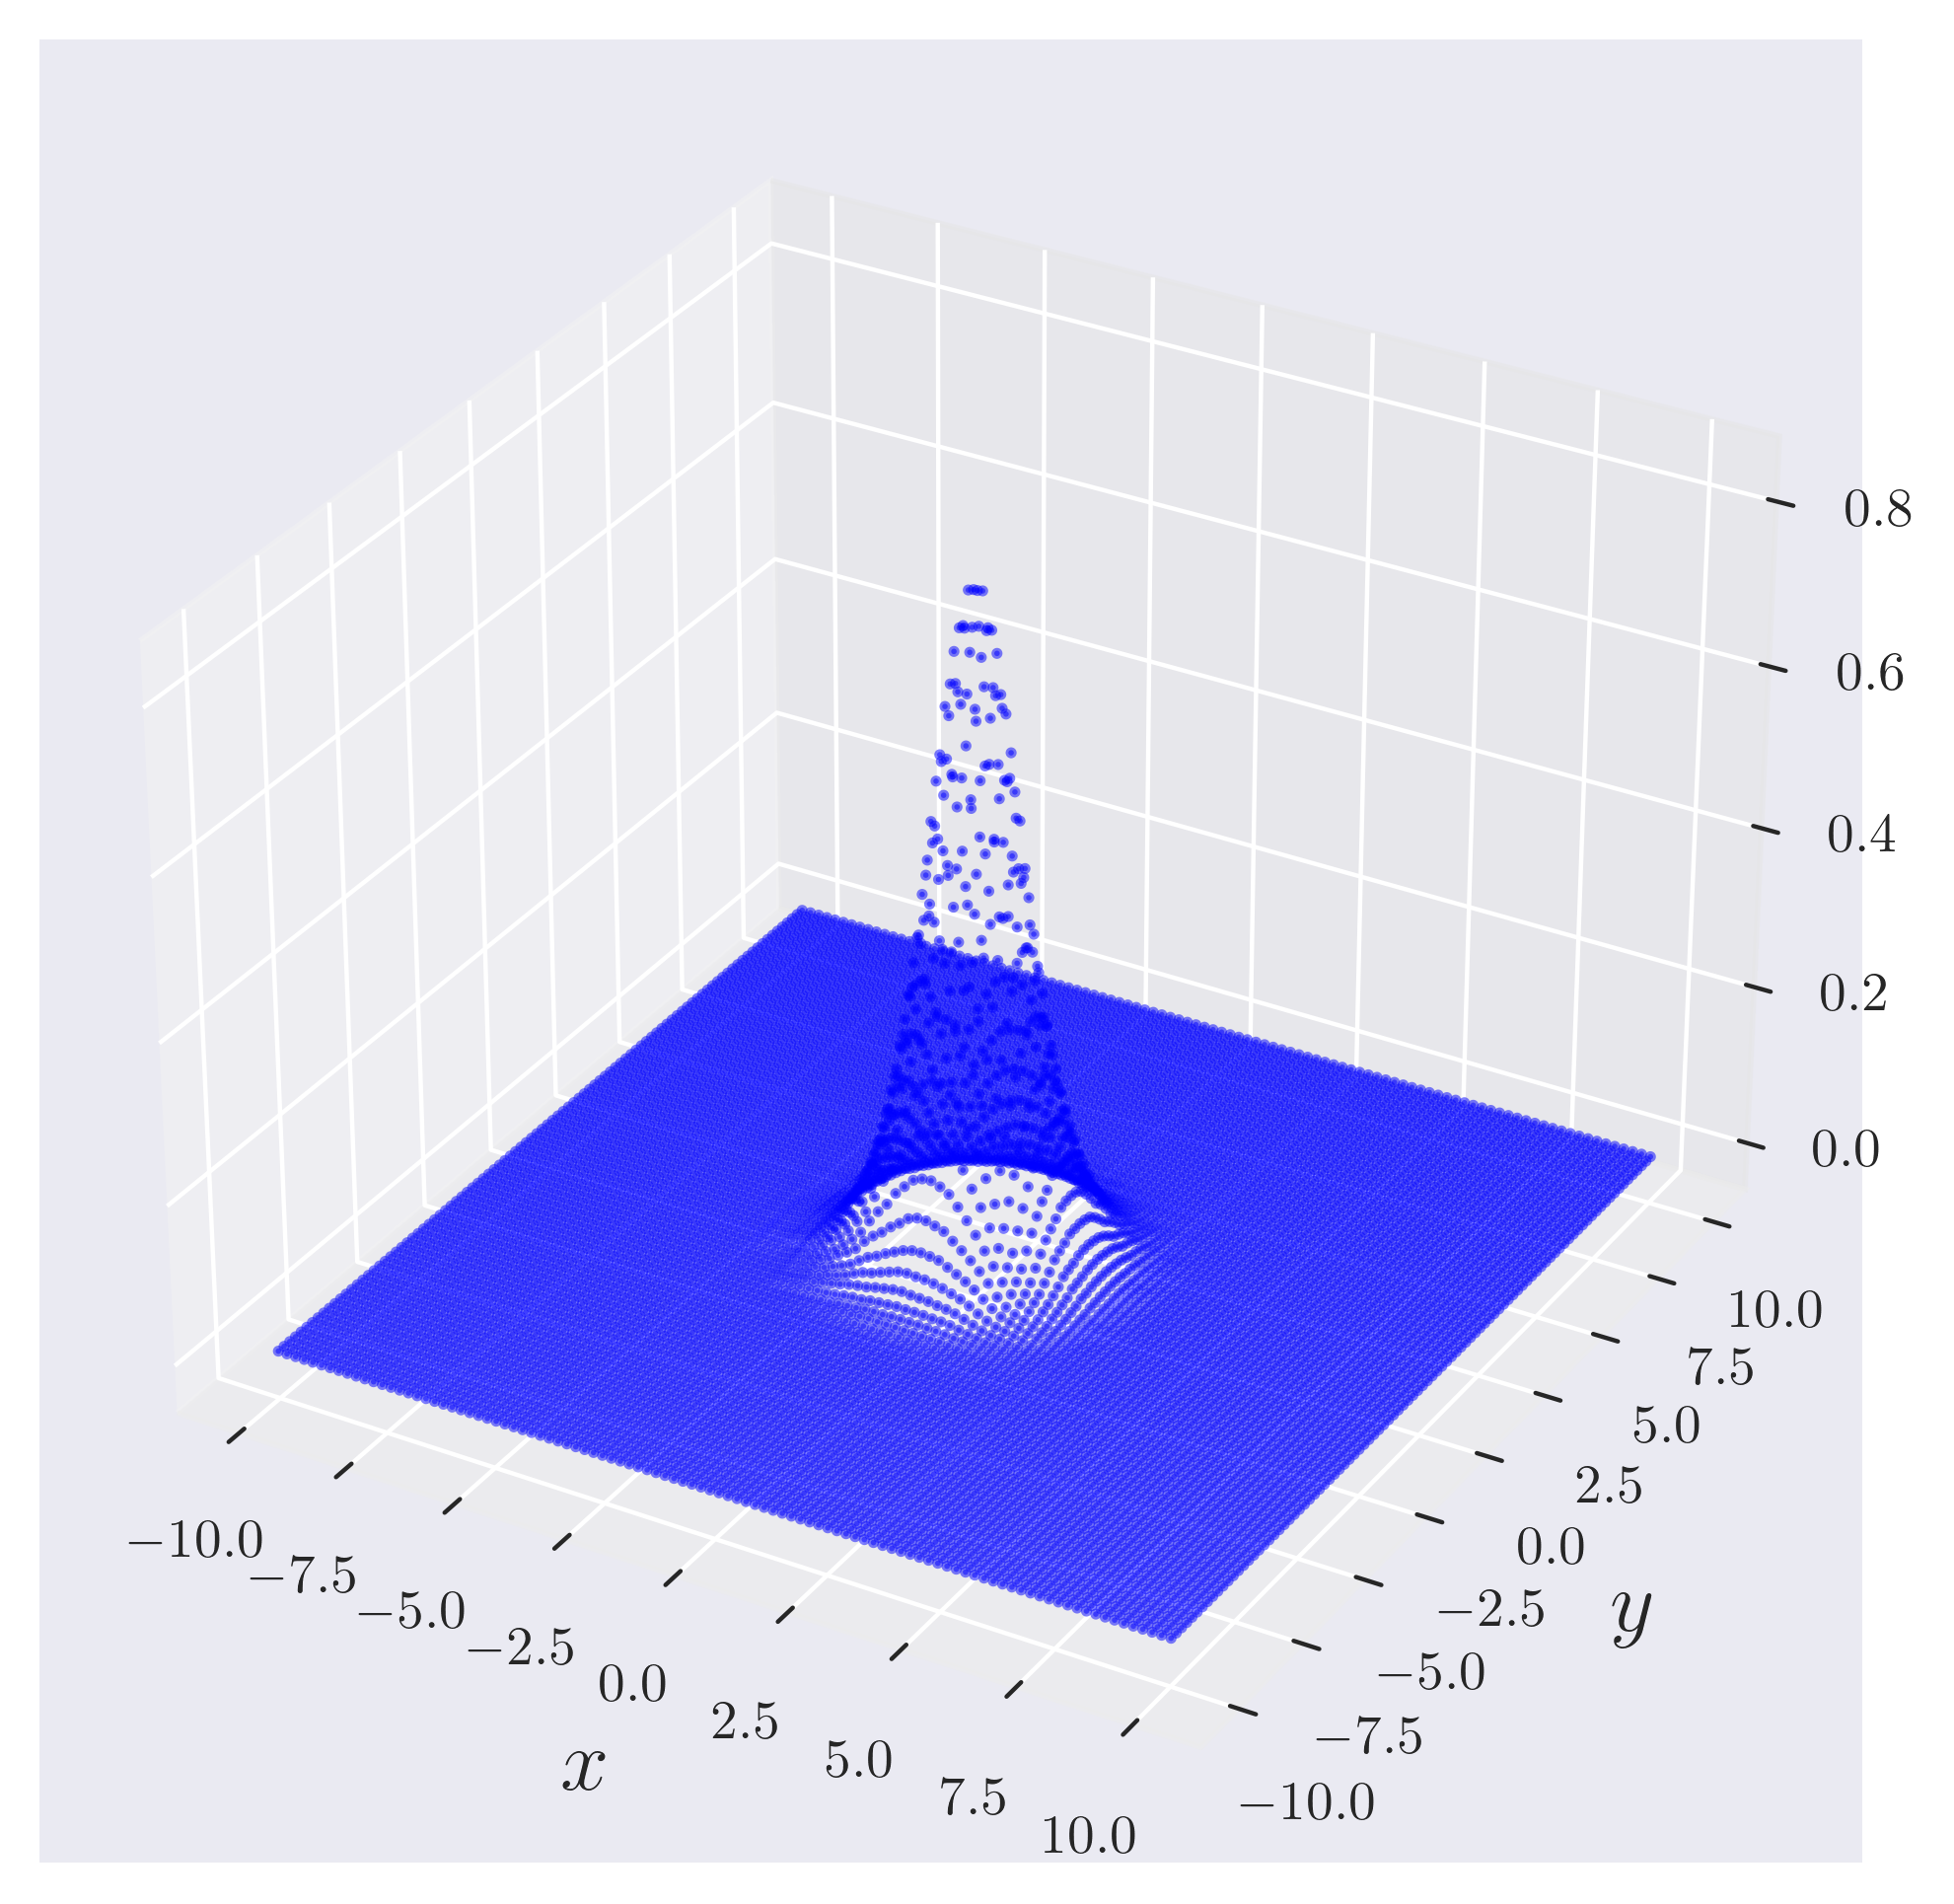

In [ ]:
fig = plt.figure(dpi=400, figsize=(8,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(xy[:,0].clone().detach().numpy(), xy[:,1].clone().detach().numpy(), z.clone().detach().numpy(), label='Feynman-Kac solution', color='blue', marker='o', s=1, alpha=0.5  )
plt.xlabel('$x$', fontsize=16);
plt.ylabel('$y$', fontsize=16);
# plt.zlabel('V(0,x)', fontsize=16);
# plt.title('Feynman-Kac solution to PDE', fontsize=16);

## Neural network approximation


$$\min_{\theta}\mathbb{E}[(Y-\phi(X_0))^2]\approx \frac{1}{J}\sum_{j}(Y-\phi(X_0))^2$$

In [ ]:
num_neurons = 25 # Modify the number of neurons

model = torch.nn.Sequential(
            torch.nn.Linear(d, num_neurons),
            torch.nn.Tanh(),
            torch.nn.Linear(num_neurons, num_neurons),
            torch.nn.Tanh(),
            torch.nn.Linear(num_neurons,1),
        )

In [ ]:
x0 = 20*torch.rand([num_samples,d]) -10 # initial condition uniformly random in [-10,10]
y_true = torch.sum(running_cost(x0.repeat([num_samples, N,1]+W[:,:-1,:]), dim=1) + terminal_cost(x0.repeat([num_samples, 1]+W[:,-1,:])

In [104]:
num_epochs = 1000
learning_rate = 1e-2
# optimizer = optim.Adam(model.parameters(), learning_rate)
optimizer = optim.SGD(model.parameters(), learning_rate,momentum=0.9)
loss_history = []
for e in range(num_epochs):
    y_pre= model(x0)
    loss = torch.nn.functional.mse_loss(y_pre, y_true)
    optimizer.zero_grad() # Zero the gradients before running the backward pass.
    loss.backward() # Backward pass: compute gradient of the loss with respect to all the learnable parameters
    loss_history.append(loss.item())
    if e % (num_epochs//10) == 0:
        print("At Epoch {}".format(e+1), "Loss = {:.9f}".format(loss.item()))
    optimizer.step() # Update the weights and biases using gradient descent. Each parameter is a Tensor. Equivalent to the above three lines, but more efficient.

At Epoch 1 Loss = 0.259768546
At Epoch 101 Loss = 0.079285771
At Epoch 201 Loss = 0.076153874
At Epoch 301 Loss = 0.075593330
At Epoch 401 Loss = 0.075385898
At Epoch 501 Loss = 0.075288922
At Epoch 601 Loss = 0.075239323
At Epoch 701 Loss = 0.075212441
At Epoch 801 Loss = 0.075197242
At Epoch 901 Loss = 0.075188361


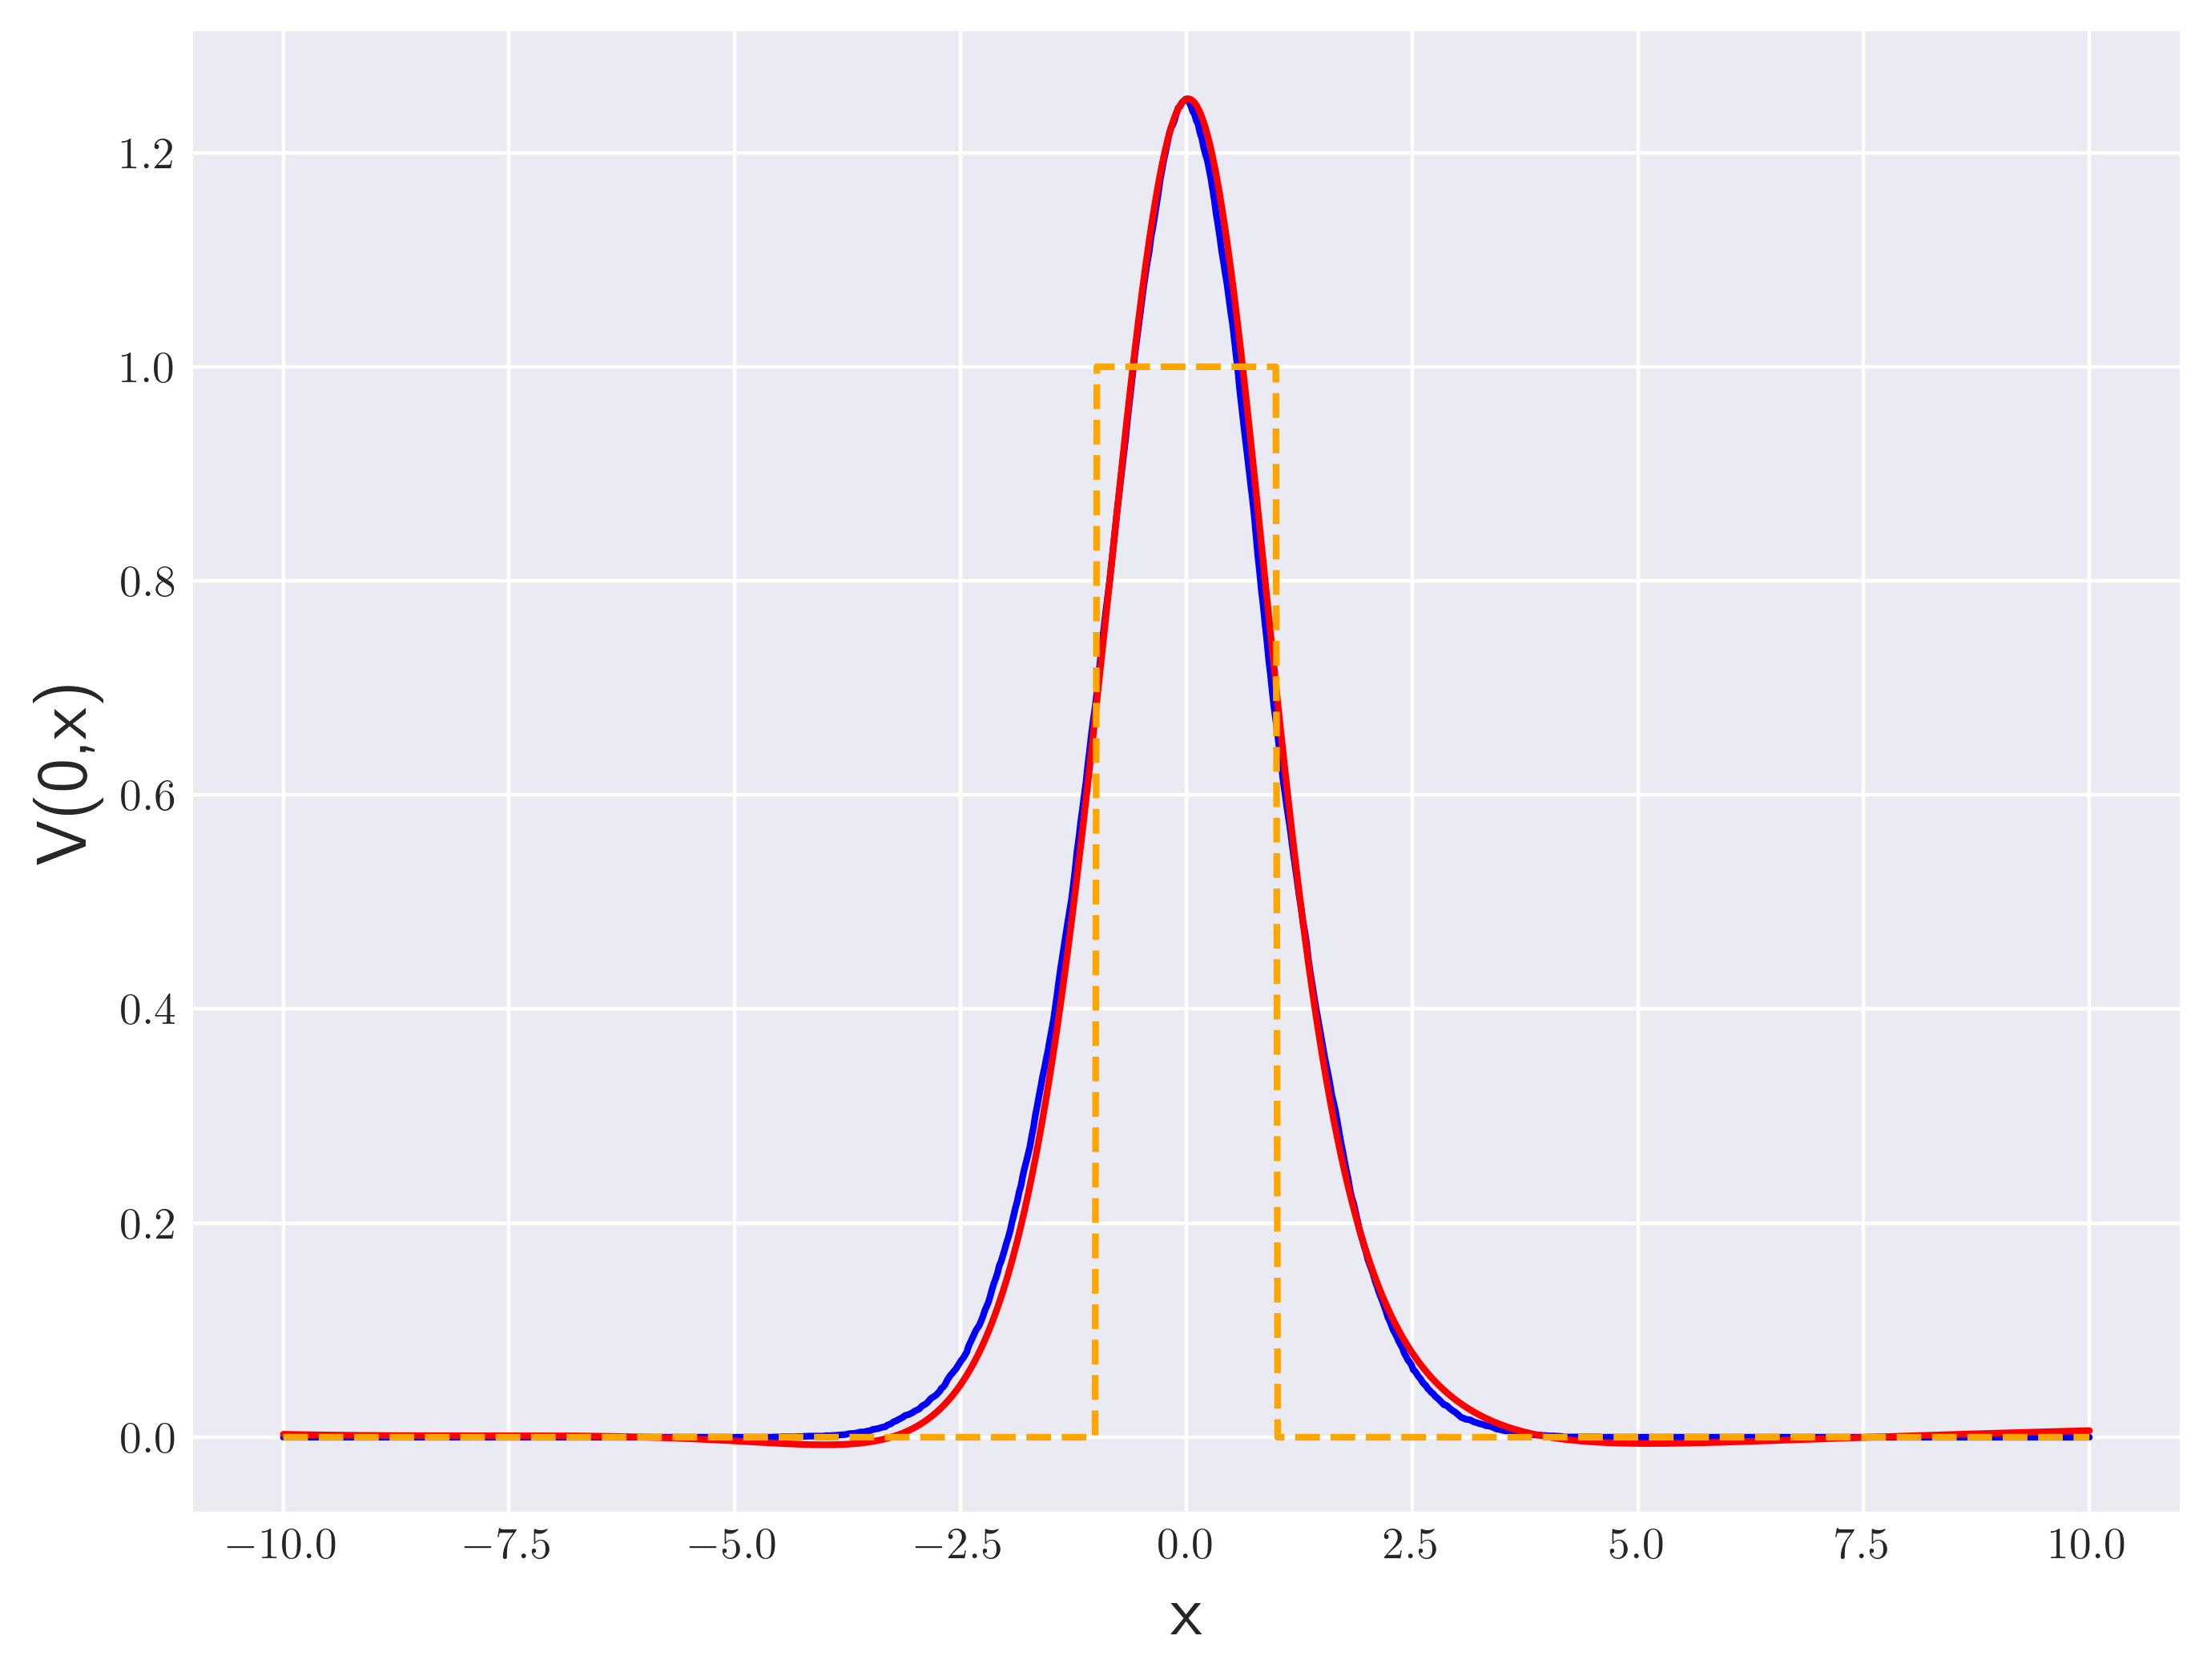

In [105]:
f = plt.figure(figsize=(8,6), dpi=400)
plt.plot(x.clone().detach().numpy(), y.clone().detach().numpy(), label='Feynman-Kac approximation', color='blue')
plt.plot(x.clone().detach().numpy(), model(x.unsqueeze(-1)).clone().detach().numpy(), '-', label='NN', color='red')
plt.plot(x.clone().detach().numpy(), terminal_cost(x).clone().detach().numpy(), '--', label='Terminal cost', color='orange')

plt.xlabel('x', fontsize=16)
plt.ylabel('V(0,x)', fontsize=16);
# plt.title('Feynman-Kac solution to PDE', fontsize=16);